# Self Attention GANの実装


## Library

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

## self attentionとは
DCGANのGeneratorではDeconvで拡大する際どうしても局所情報の拡大になってしまい、大域的な情報が含まれない<br>
大域的な情報を含んだ拡大を実現するのがself attentionという技術

## 1x1 Convolutions (pointwise convolution)とは
出力チャネルが1だけ -> 入力xをチャネルごとに線形和をとったもの<br>
出力チャネルが複数 -> 異なる係数で（重み）でチャネルごとに線形和をとったものを出力チャネル分だけ用意する<br>

次元圧縮とも言える<br>
情報が欠落しにくい線形和の係数を学習してくれる

次元が圧縮され、計算量が少なくなることを活かして、エッジ端末で使われるmobile netでも使用される

## Spectral Normalizationとは
ネットワークの重みの正規化<br>
GANがうまく学習するにはDiscriminatorがリプシッツ連続星を保つ必要がある→<br>
リプシッツ連続をDiscriminatorのネットワークが有するにはどうすればいいか→<br>
Spectral Normalizationで重みを正規化する

## self attentionモジュールの実装

In [3]:
class Self_Attention(nn.Module):
    """
    self attentionのlayer
    """
    
    def __init__(self, in_dim):
        """
        query:
            元の入力xの転置に対応するもの
        key:
            元の入力xに対応するもの
        value:
            attention mapと掛け算する対象
        """
        super(Self_Attention, self).__init__()
        
        # pointwise convolutionを用意
        # pointwiseなのでkernel_size=1
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        # attention map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)
        
        # もとの入力ｘとself attention map(o)を加算するときの係数
        # 最初はgammma=0で学習させていく
        # nn.Parameter : pytocrhで学習可能な変数を作成する命令
        # これはインスタンス変数で保持しておく必要があるのかな？
        self.gamma = nn.Parameter(torch.zeros(1))  
        
    def forward(self, x):
        # 入力変数  B, C, W, H
        X = x
        
        # 畳み込み後にサイズを変更 B, C', W, H -> B, C', N
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # channelのサイズが変わるので-1
        proj_query = proj_query.permute(0, 2, 1)  # 転置　　B, N, C'
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # channelのサイズが変わるので-1
                                                                                   # B, C', N

        # 掛け算
        S = torch.bmm(proj_query, proj_key)  # bmm : バッチごとの掛け算
        
        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするsoftmax
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置
        
        # self attentino mapを計算
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # B, C, N
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))  # bmm : バッチごとの掛け算
        # attention mapは転置して掛け算
        
        # self attentino mapであるoのテンソルサイズをXに揃えて出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma*o
        
        return out, attention_map  # attention_mapはattentionの強さを可視化するために使用

## Generatorの実装
DCGANからの変更点
- Deconv層にSpectral Normalizationを追加する
- self attentionモジュールを追加する

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1= nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
        
        # self attention層を追加
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        # self attention層を追加
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(
            # Spectral Normalizationはしない
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())  # -1~1の出力になる
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2  #  outと2つのattention_mapを返す
        
        

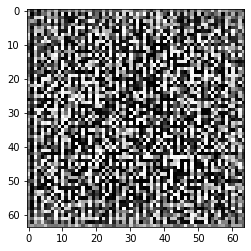

In [5]:
# 動作確認
# どこかにミスがある前提で動作確認するほうがいい
# 修正するための動作確認だから
import matplotlib.pyplot as plt
%matplotlib inline

# 偽画像の生成
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, attention_map1, attention_map2 = G(input_z)

# 偽画像の表示
image_transformed = fake_images[0][0].detach().numpy()  # 64x64
plt.imshow(image_transformed, 'gray')
plt.show()


## Discriminator
DCGANからの変更点(Generatorと一緒)
- Deconv層にSpectral Normalizationを追加する
- self attentionモジュールを追加する

In [6]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, image_size=64):
        super(Discriminator, self).__init__()
        
        # layerを用意しておく
        self.layer1 = nn.Sequential(
            # Spectral normalization
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            # Spectral normalization
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            # Spectral normalization
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size*4)
        
        self.layer4 = nn.Sequential(
            # Spectral normalization
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

In [7]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

#　偽画像生成して判定
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)
d_out, attention_map1, attention_map2 = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.4955]]]], grad_fn=<SigmoidBackward>)


## DataLoaderの作成
変更点はなし

In [8]:
def make_datapath_list():
    """
    学習の画像データへのファイルパスリストを作成
    """
    
    train_img_list = []
    for img_idx in range(200):
        img_path = './data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [9]:
class ImageTransform():
    """画像の前処理クラス"""
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [10]:
class GAN_Img_Dataset(data.Dataset):
    '''
    画像のDatasetクラス
    '''
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        画像のTensor形式のデータを取得
        """
        img_path = self.file_list[index]
        img = Image.open(img_path)  # 高さ、幅、色【白黒】
        
        # 画像の前処理
        img_transformed = self.transform(img)
        
        return img_transformed

In [11]:
# DataLoaderの作成と動作確認

# ファイルリストの作成
train_img_list = make_datapath_list()

# Datasetを作成
mean  = (0.5,)  # カンマがないとエラーになる
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
images = next(batch_iterator)
print(images.size())  # torch.Size([])


torch.Size([64, 1, 64, 64])


## 学習
SAGANでは損失関数に hinge version of the adversarial lossを使う<br>
logなし、平均を取る<br>
Discriminatorの方でReLU使ってる<br>

GANの損失関数は多数提案されているが、それらは経験的にうまくいくからと言う理由で使用されていることが多い

In [12]:
# モデルを学習させる関数を作成

def train_model(G, D, dataloader, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    z_dim = 20
    mini_batch_size = 64  # この一文はなんのためにあるの？
    
    # ハードに送って
    G.to(device)
    D.to(device)
    
    # 訓練モードに設定
    G.train()
    D.train()

    torch.backends.cudnn.bencmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタのセット
    iteration = 1
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs):
        # 開始時刻
        t_epoch_start = time.time()
        epoch_loss_g = 0.0
        epoch_loss_d = 0.0
        
        print('------------')
        print('Epoch : {}/{}'.format(epoch, num_epochs))
        print('------------')
        print('(train)')
        
        # データローダからminibatcずつ取り出すループ
        for images in dataloader:  # ここはiteratorにしなくても取り出してくれる
            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            if images.size()[0] == 1:
                continue
            
            # modelは○.to(device)だけでいいけど
            # データは ○ = ○.to(device)で再度代入する必要がある
            images = images.to(device)
            
            # epochの最後のイテレーションはミニバッチサイズの数が少なくなる
            mini_batch_size = images.size()[0]
            
            # 真の画像を判定
            d_out_real, _, _ = D(images)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            # D, Gどちらもattention mapが生成される
            # Dのattention mapってどんなもの？
            
            # 誤差計算　hinge version of the adversarial lossに変更
            d_loss_real = torch.nn.ReLU()(1.0-d_out_real).mean()
            # d_out_realが１以上の場合誤差0になる
            
            d_loss_fake = torch.nn.ReLU()(1.0+d_out_fake).mean()
            # d_loss_fakeが−１以下なら誤差0になる
            
            d_loss = d_loss_real + d_loss_fake
            
            # backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差計算　hinge version of the adversarial lossに変更
            g_loss = - d_out_fake.mean()  # マイナス忘れ注意
            
            # backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 記録
            # --------------------
            epoch_loss_d += d_loss.item()  # .item()忘れがち
            epoch_loss_g += g_loss.item()
            iteration += 1 
            
        # epochごとのlossと計算時間
        t_epoch_finish = time.time()
        print('------------')
        print('epoch {} || Epoch_D_Loss :{:.4f} || Epoch_G_Loss :{:.4f}'.format(
            epoch, epoch_loss_d/batch_size, epoch_loss_g/batch_size))
        print('timer : {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
    return G, D

In [13]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__  # オブジェクトのクラス名を取得
    if classname.find('Conv') != -1:  # 文字列中の任意の文字列の位置を取得　含まれていなければ-1
        # Conv2dとConvTranspose2dの重みの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの重みの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# 重みの初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print('ネットワークの初期化完了')

ネットワークの初期化完了


In [14]:
# 学習・検証の実施
num_epochs = 300
G, D = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

# Discriminatorのlossが最初から０になっている -> g_lossの式にマイナスを付け忘れていたため

使用デバイス： cuda:0
------------
Epoch : 0/300
------------
(train)
------------
epoch 0 || Epoch_D_Loss :0.1574 || Epoch_G_Loss :0.0195
timer : 3.0071 sec.
------------
Epoch : 1/300
------------
(train)
------------
epoch 1 || Epoch_D_Loss :0.1736 || Epoch_G_Loss :0.1687
timer : 2.7432 sec.
------------
Epoch : 2/300
------------
(train)
------------
epoch 2 || Epoch_D_Loss :0.0372 || Epoch_G_Loss :0.1106
timer : 2.7506 sec.
------------
Epoch : 3/300
------------
(train)
------------
epoch 3 || Epoch_D_Loss :0.0037 || Epoch_G_Loss :0.1379
timer : 2.7198 sec.
------------
Epoch : 4/300
------------
(train)
------------
epoch 4 || Epoch_D_Loss :0.0887 || Epoch_G_Loss :0.1092
timer : 2.7510 sec.
------------
Epoch : 5/300
------------
(train)
------------
epoch 5 || Epoch_D_Loss :0.0053 || Epoch_G_Loss :0.1842
timer : 2.7319 sec.
------------
Epoch : 6/300
------------
(train)
------------
epoch 6 || Epoch_D_Loss :0.1005 || Epoch_G_Loss :0.0997
timer : 2.7446 sec.
------------
Epoch : 7/300

------------
epoch 59 || Epoch_D_Loss :0.1612 || Epoch_G_Loss :0.0380
timer : 2.8090 sec.
------------
Epoch : 60/300
------------
(train)
------------
epoch 60 || Epoch_D_Loss :0.1596 || Epoch_G_Loss :0.0692
timer : 2.8078 sec.
------------
Epoch : 61/300
------------
(train)
------------
epoch 61 || Epoch_D_Loss :0.1675 || Epoch_G_Loss :0.0194
timer : 2.8112 sec.
------------
Epoch : 62/300
------------
(train)
------------
epoch 62 || Epoch_D_Loss :0.1914 || Epoch_G_Loss :0.0607
timer : 2.8068 sec.
------------
Epoch : 63/300
------------
(train)
------------
epoch 63 || Epoch_D_Loss :0.1619 || Epoch_G_Loss :0.0583
timer : 2.8107 sec.
------------
Epoch : 64/300
------------
(train)
------------
epoch 64 || Epoch_D_Loss :0.1700 || Epoch_G_Loss :0.0493
timer : 2.8103 sec.
------------
Epoch : 65/300
------------
(train)
------------
epoch 65 || Epoch_D_Loss :0.1731 || Epoch_G_Loss :0.0477
timer : 2.8157 sec.
------------
Epoch : 66/300
------------
(train)
------------
epoch 66 || Ep

------------
epoch 118 || Epoch_D_Loss :0.1277 || Epoch_G_Loss :0.0478
timer : 2.8173 sec.
------------
Epoch : 119/300
------------
(train)
------------
epoch 119 || Epoch_D_Loss :0.1313 || Epoch_G_Loss :0.0873
timer : 2.8100 sec.
------------
Epoch : 120/300
------------
(train)
------------
epoch 120 || Epoch_D_Loss :0.1268 || Epoch_G_Loss :0.0638
timer : 2.8084 sec.
------------
Epoch : 121/300
------------
(train)
------------
epoch 121 || Epoch_D_Loss :0.1221 || Epoch_G_Loss :0.0916
timer : 2.8152 sec.
------------
Epoch : 122/300
------------
(train)
------------
epoch 122 || Epoch_D_Loss :0.1296 || Epoch_G_Loss :0.0572
timer : 2.8202 sec.
------------
Epoch : 123/300
------------
(train)
------------
epoch 123 || Epoch_D_Loss :0.1298 || Epoch_G_Loss :0.0777
timer : 2.8085 sec.
------------
Epoch : 124/300
------------
(train)
------------
epoch 124 || Epoch_D_Loss :0.1120 || Epoch_G_Loss :0.0859
timer : 2.8084 sec.
------------
Epoch : 125/300
------------
(train)
------------


------------
epoch 177 || Epoch_D_Loss :0.0867 || Epoch_G_Loss :0.1207
timer : 2.8327 sec.
------------
Epoch : 178/300
------------
(train)
------------
epoch 178 || Epoch_D_Loss :0.0814 || Epoch_G_Loss :0.1380
timer : 2.8073 sec.
------------
Epoch : 179/300
------------
(train)
------------
epoch 179 || Epoch_D_Loss :0.0644 || Epoch_G_Loss :0.1252
timer : 2.8140 sec.
------------
Epoch : 180/300
------------
(train)
------------
epoch 180 || Epoch_D_Loss :0.0990 || Epoch_G_Loss :0.1315
timer : 2.8074 sec.
------------
Epoch : 181/300
------------
(train)
------------
epoch 181 || Epoch_D_Loss :0.0767 || Epoch_G_Loss :0.1132
timer : 2.8292 sec.
------------
Epoch : 182/300
------------
(train)
------------
epoch 182 || Epoch_D_Loss :0.0793 || Epoch_G_Loss :0.1201
timer : 2.8168 sec.
------------
Epoch : 183/300
------------
(train)
------------
epoch 183 || Epoch_D_Loss :0.0752 || Epoch_G_Loss :0.1351
timer : 2.8120 sec.
------------
Epoch : 184/300
------------
(train)
------------


------------
epoch 236 || Epoch_D_Loss :0.0399 || Epoch_G_Loss :0.1892
timer : 2.8003 sec.
------------
Epoch : 237/300
------------
(train)
------------
epoch 237 || Epoch_D_Loss :0.0524 || Epoch_G_Loss :0.1595
timer : 2.8217 sec.
------------
Epoch : 238/300
------------
(train)
------------
epoch 238 || Epoch_D_Loss :0.0461 || Epoch_G_Loss :0.1853
timer : 2.8135 sec.
------------
Epoch : 239/300
------------
(train)
------------
epoch 239 || Epoch_D_Loss :0.0466 || Epoch_G_Loss :0.1590
timer : 2.8033 sec.
------------
Epoch : 240/300
------------
(train)
------------
epoch 240 || Epoch_D_Loss :0.0570 || Epoch_G_Loss :0.1766
timer : 2.8061 sec.
------------
Epoch : 241/300
------------
(train)
------------
epoch 241 || Epoch_D_Loss :0.0450 || Epoch_G_Loss :0.1800
timer : 2.8160 sec.
------------
Epoch : 242/300
------------
(train)
------------
epoch 242 || Epoch_D_Loss :0.0382 || Epoch_G_Loss :0.1854
timer : 2.7977 sec.
------------
Epoch : 243/300
------------
(train)
------------


------------
epoch 295 || Epoch_D_Loss :0.0343 || Epoch_G_Loss :0.2405
timer : 2.7992 sec.
------------
Epoch : 296/300
------------
(train)
------------
epoch 296 || Epoch_D_Loss :0.0361 || Epoch_G_Loss :0.2018
timer : 2.8058 sec.
------------
Epoch : 297/300
------------
(train)
------------
epoch 297 || Epoch_D_Loss :0.0254 || Epoch_G_Loss :0.2321
timer : 2.8023 sec.
------------
Epoch : 298/300
------------
(train)
------------
epoch 298 || Epoch_D_Loss :0.0263 || Epoch_G_Loss :0.2363
timer : 2.7992 sec.
------------
Epoch : 299/300
------------
(train)
------------
epoch 299 || Epoch_D_Loss :0.0190 || Epoch_G_Loss :0.2204
timer : 2.7956 sec.


TypeError: Invalid shape (1, 64, 64) for image data

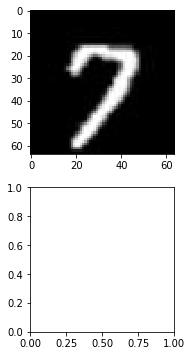

In [15]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G.eval()
fake_images = G(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0,5):
    # 上段に訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段に生成データ
    plt.subplot(2, 5, i+6)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

In [ ]:
# attention mapの表示
fig = plt.figure(figsize=(15, 6))

for i in range(0,5):
    # 上段に生成したデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段にattention map１の画像中央のピクセルのデータを
    plt.subplot(2, 5, i+6)
    am = am[i].view(16,16,16)
    am = am[7][7]  # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')
    